# Issues and solutions

This notebook is for solving reported issues here: https://github.com/hcp4715/dockerHDDM/issues

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current kabuki version is:  0.6.4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.12.0


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [3]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


## Fixing issue 2
https://github.com/hcp4715/dockerHDDM/issues/2

I use the example data, `data_cavanagh`, to test the function

In [4]:
def ms1_1(id, df=None, samples=None, burn=None, thin=1, save_name="ms1_1_tmp"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(dbs, Treatment(0))", # I changed the variable name to dbs in the example data.
                           group_only_regressors=True,
                           keep_regressor_trace=True)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [5]:
%%time

chains = 4

file_names = glob.glob("ms1_1_tmp" + "_chain_*[!db]", recursive=False)

if file_names:
    file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
    ms1_1res = []
    for fname in file_names:
        print('current loading: ', fname, '\n')
        ms4res.append(hddm.load(fname))
else:
    ms1_1res = p_map(partial(ms1_1, df=data_cavanagh, samples=200, burn=100, save_name="ms1_1_tmp"), range(chains))

running chain 0 for model ms1_1_tmp


  0%|          | 0/4 [00:00<?, ?it/s]

Adding these covariates:
running chain 1 for model ms1_1_tmp['v_Intercept', 'v_C(dbs, Treatment(0))[T.1]']

Adding these covariates:
['v_Intercept', 'v_C(dbs, Treatment(0))[T.1]']
running chain 2 for model ms1_1_tmp
Adding these covariates:
['v_Intercept', 'v_C(dbs, Treatment(0))[T.1]']
running chain 3 for model ms1_1_tmp
Adding these covariates:
['v_Intercept', 'v_C(dbs, Treatment(0))[T.1]']


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  1%                  ] 3 of 200 complete in 0.8 sec[                  1%                  ] 3 of 200 complete in 0.8 sec[                  1%                  ] 3 of 200 complete in 0.9 sec[                  1%                  ] 3 of 200 complete in 0.9 sec[                  2%                  ] 5 of 200 complete in 1.4 sec[                  2%                  ] 5 of 200 complete in 1.5 sec[                  2%                  ] 5 of 200 complete in 1.5 sec[                  2%                  ] 5 of 200 complete in 1.5 sec[-                 3%                  ] 7 of 200 complete in 2.0 sec[-                 3%                  ] 7 of 200 complete in 2.1 sec[-                 3%                  ] 7 of 200 complete in 2.1 sec[-                 3%                  ] 7 of 200 complete in 2.1 sec[-                 4%                  ] 9 of 200 complete in 2.6 sec[-                 4%                  ] 9 of 200 complete in 2.7 sec[-                 4%            

 [---------------  39%                  ] 79 of 200 complete in 19.3 sec[---------------  40%                  ] 80 of 200 complete in 19.6 sec[---------------  40%                  ] 81 of 200 complete in 19.8 sec[---------------  39%                  ] 79 of 200 complete in 19.8 sec[---------------  41%                  ] 82 of 200 complete in 19.9 sec[---------------  40%                  ] 81 of 200 complete in 20.3 sec[---------------  41%                  ] 83 of 200 complete in 20.3 sec[---------------  42%                  ] 84 of 200 complete in 20.5 sec[---------------- 42%                  ] 85 of 200 complete in 20.7 sec[---------------- 43%                  ] 86 of 200 complete in 20.9 sec[---------------  42%                  ] 84 of 200 complete in 21.0 sec[---------------- 43%                  ] 87 of 200 complete in 21.2 sec[---------------- 44%                  ] 88 of 200 complete in 21.3 sec[---------------- 44%                  ] 89 of 200 complete in 21.6 sec[----

 [-----------------78%---------         ] 157 of 200 complete in 38.0 sec[-----------------78%---------         ] 156 of 200 complete in 37.9 sec[-----------------78%---------         ] 156 of 200 complete in 38.4 sec[-----------------79%----------        ] 158 of 200 complete in 38.6 sec[-----------------79%----------        ] 159 of 200 complete in 38.6 sec[-----------------80%----------        ] 160 of 200 complete in 38.7 sec[-----------------79%----------        ] 159 of 200 complete in 39.1 sec[-----------------80%----------        ] 161 of 200 complete in 39.3 sec[-----------------81%----------        ] 162 of 200 complete in 39.2 sec[-----------------81%----------        ] 163 of 200 complete in 39.3 sec[-----------------81%----------        ] 162 of 200 complete in 39.7 sec[-----------------82%-----------       ] 164 of 200 complete in 39.7 sec[-----------------82%-----------       ] 164 of 200 complete in 40.0 sec[-----------------83%-----------       ] 166 of 200 complete in

In [6]:
%%time
InfData_ms1_1 = InferenceDataFromHDDM(ms1_1res, nppc = 10, save_name="ms1_1_tmp")

start converting ms1_1_tmp


  0%|          | 0/4 [00:00<?, ?it/s]


started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 12.3 sec[----------       28%                  ] 4 of 14 complete in 12.4 sec[----------       28%                  ] 4 of 14 complete in 12.3 sec[----------       28%                  ] 4 of 14 complete in 12.4 sec[-------------    35%                  ] 5 of 14 complete in 24.1 sec[-------------    35%                  ] 5 of 14 complete in 24.1 sec[-------------    35%                  ] 5 of 14 complete in 24.3 sec[-------------    35%                  ] 5 of 14 complete in 24.4 sec[---------------- 42%                  ] 6 of 14 complete in 35.3 sec[---------------- 42%                  ] 6 of 14 complete in 35.5 sec[---------------- 42%                  ] 6 of 14 complete in 35.7 sec[---------------- 42%                  ] 6 of 14 complete in 35.8 sec[-

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 6.9 sec[----------       28%                  ] 4 of 14 complete in 7.0 sec[----------       28%                  ] 4 of 14 complete in 7.0 sec[----------       28%                  ] 4 of 14 complete in 6.9 sec[-------------    35%                  ] 5 of 14 complete in 14.1 sec[-------------    35%                  ] 5 of 14 complete in 14.3 sec[-------------    35%                  ] 5 of 14 complete in 14.3 sec[-------------    35%                  ] 5 of 14 complete in 14.4 sec[---------------- 42%                  ] 6 of 14 complete in 21.5 sec[---------------- 42%                  ] 6 of 14 complete in 21.6 sec[---------------- 42%                  ] 6 of 14 complete in 21.7 sec[---------------- 42%                  ] 6 of 14 complete in 21.8 sec[------

In [7]:
InfData_ms1_1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

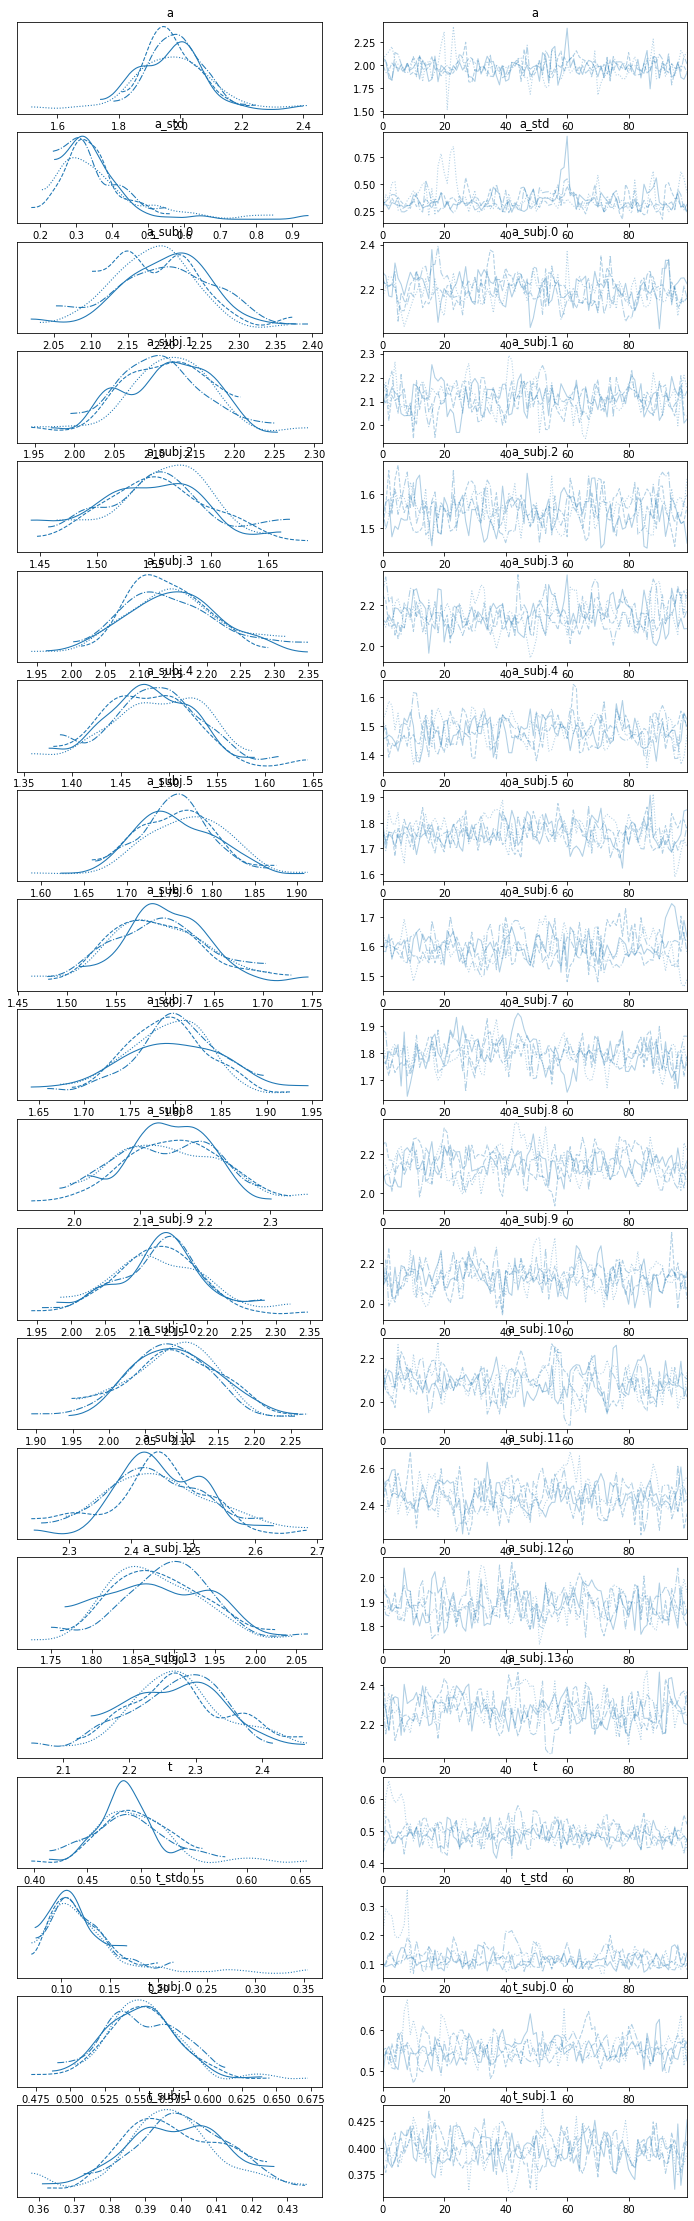

In [8]:
az.plot_trace(InfData_ms1_1)